# Task 4: Proxy Target Variable Engineering

## 📋 Objective
Create a credit risk target variable since we don't have a pre-existing "credit risk" column in our data. We'll programmatically identify "disengaged" customers and label them as high-risk proxies using RFM analysis and clustering.

## 🎯 The 4 Required Steps:
1. **Calculate RFM Metrics** - Recency, Frequency, Monetary for each customer
2. **Cluster Customers** - Use K-Means to segment into 3 groups based on RFM profiles
3. **Define High-Risk Label** - Identify least engaged cluster as high-risk
4. **Integrate Target Variable** - Merge is_high_risk back to main dataset

## 📁 Import Modules

In [15]:
# ============================================
# SETUP AND IMPORTS
# ============================================

import sys
import os
sys.path.append('..')  # Add src to path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import Task 4 classes
from src.target_engineering import (
    RFMMetricsCalculator,
    RFMClustering,
    HighRiskLabelAssigner,
    TargetVariableIntegrator,
    TargetEngineeringPipeline
)

print(" Task 4 modules imported successfully!")

 Task 4 modules imported successfully!


## Step 1: Calculate RFM Metrics

For each CustomerId, we calculate:
- **Recency**: Days since last transaction (from snapshot date)
- **Frequency**: Number of transactions  
- **Monetary**: Total amount spent (absolute value)

We define a snapshot date consistently for recency calculation.

📊 STEP 1: CALCULATING RFM METRICS
Loading raw data from: ..\data\raw\data.csv
✅ Loaded raw data: 95,662 transactions × 16 columns
Columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']
📅 Snapshot date for recency calculation: 2019-02-14 10:01:28+00:00
✅ RFM metrics calculated for 3742 unique customers
📊 RFM Summary:
           Recency    Frequency      Monetary
count  3742.000000  3742.000000  3.742000e+03
mean     31.461251    25.564404  2.118644e+05
std      27.118932    96.929602  2.105998e+06
min       1.000000     1.000000  0.000000e+00
25%       6.000000     2.000000  5.000000e+03
50%      25.000000     7.000000  2.600000e+04
75%      54.000000    20.000000  8.978975e+04
max      91.000000  4091.000000  8.346600e+07

📋 RFM Data Sample (first 5 customers):
                 Recency  Frequen

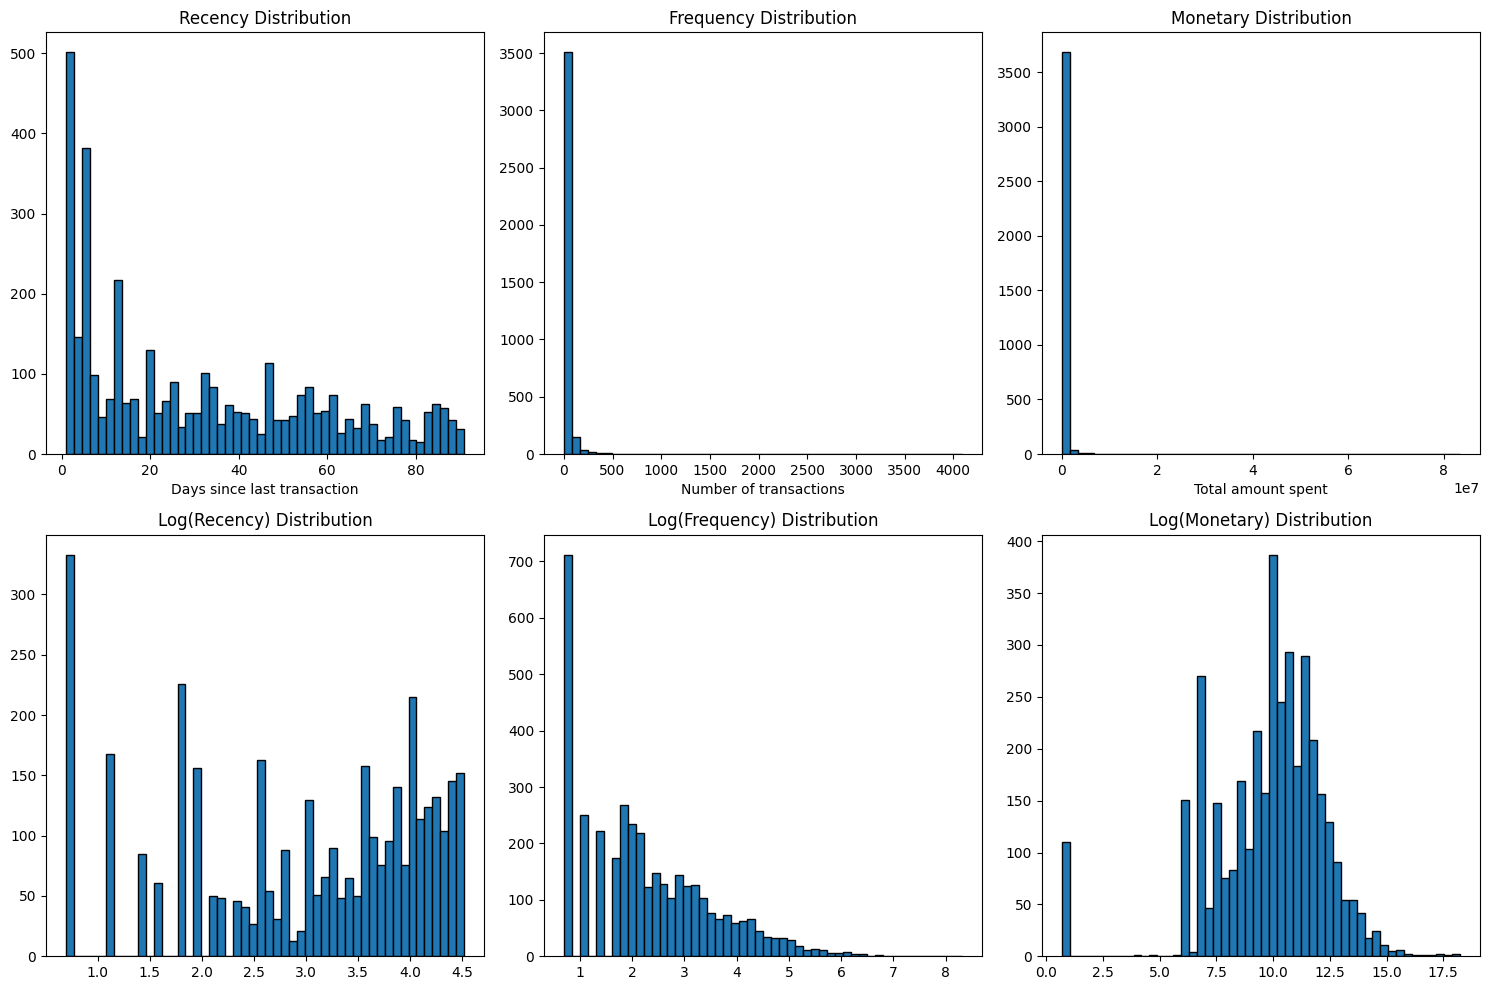

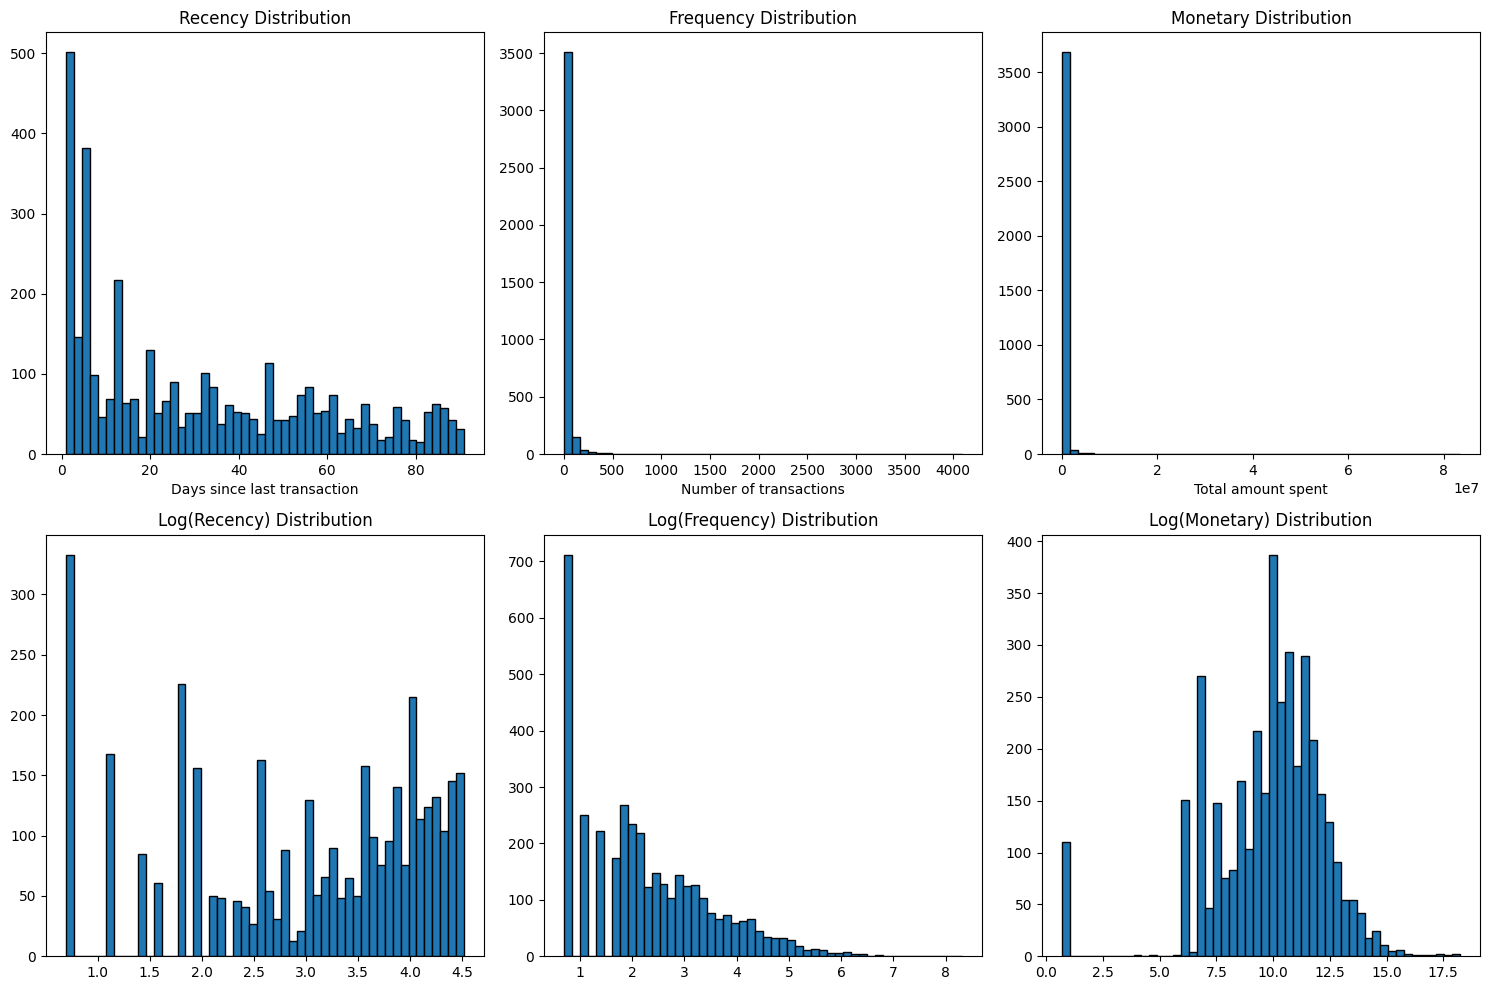

In [16]:
# ============================================
# STEP 1: CALCULATE RFM METRICS
# ============================================

print("📊 STEP 1: CALCULATING RFM METRICS")
print("="*60)

# IMPORTANT: Use RAW data for RFM calculation, not engineered features
# RFM needs original transaction details
raw_data_path = Path('../data/raw/data.csv')
print(f"Loading raw data from: {raw_data_path}")

if raw_data_path.exists():
    df_raw = pd.read_csv(raw_data_path)
    print(f"✅ Loaded raw data: {df_raw.shape[0]:,} transactions × {df_raw.shape[1]} columns")
    print(f"Columns: {df_raw.columns.tolist()}")
else:
    # Fallback to processed data
    print("⚠️  Raw data not found, using processed data...")
    data_path = Path('../data/processed/task3_features_engineered.parquet')
    df_raw = pd.read_parquet(data_path)
    print(f"⚠️  Using processed data: {df_raw.shape}")

# Initialize RFM calculator
rfm_calculator = RFMMetricsCalculator(
    customer_col='CustomerId',
    datetime_col='TransactionStartTime',
    amount_col='Amount'
)

# Calculate RFM metrics
rfm_data = rfm_calculator.transform(df_raw)

# Display RFM results
print("\n📋 RFM Data Sample (first 5 customers):")
print(rfm_data.head())

# Visualize RFM distributions
print("\n📈 Visualizing RFM Distributions...")
rfm_calculator.plot_rfm_distributions()

## Step 2: Cluster Customers

### What we're doing:
Using K-Means clustering algorithm to segment customers into 3 distinct groups based on their RFM profiles.

Key steps:
1. Pre-process (scale) the RFM features appropriately
2. Apply K-Means with n_clusters=3
3. Set random_state=42 for reproducibility
4. Evaluate clustering quality with silhouette score

In [18]:
# ============================================
# STEP 2: CLUSTER CUSTOMERS WITH K-MEANS
# ============================================

print("\n🔍 STEP 2: CLUSTERING CUSTOMERS")
print("="*60)

# Initialize clustering
clusterer = RFMClustering(
    n_clusters=3,           # Instruction: "segment customers into 3 distinct groups"
    random_state=42,        # Instruction: "Set a random_state during clustering"
    features_to_scale=['Recency_Log', 'Frequency_Log', 'Monetary_Log']
)

# Fit clustering on RFM data
clusterer.fit(rfm_data)

# Assign clusters to RFM data
rfm_with_clusters = clusterer.transform(rfm_data)

# Display clustering results
print("\n📊 Cluster Assignments:")
print(rfm_with_clusters[['Recency', 'Frequency', 'Monetary', 'Cluster']].head())

# Visualize clusters
print("\n📈 Visualizing RFM Clusters...")
clusterer.plot_clusters(rfm_data)

# Analyze cluster profiles
print("\n📋 Analyzing Cluster Characteristics...")
cluster_profiles = clusterer.get_cluster_profiles(rfm_data)


🔍 STEP 2: CLUSTERING CUSTOMERS


TypeError: RFMClustering.__init__() got an unexpected keyword argument 'features_to_scale'

## Step 3: Define and Assign High-Risk Label

Analyzing the clusters to determine which represents the least engaged (highest-risk) customer segment.

High-risk characteristics (typically):
- **Low frequency** - Few transactions
- **Low monetary value** - Small total spending  
- **High recency** - Long time since last transaction

To create a binary target column `is_high_risk` where:
- 1 = Customers in high-risk cluster
- 0 = All other customers

In [8]:
# ============================================
# STEP 3: ASSIGN HIGH-RISK LABELS
# ============================================

print("\n🏷️ STEP 3: ASSIGNING HIGH-RISK LABELS")
print("="*60)

# Initialize label assigner
label_assigner = HighRiskLabelAssigner(risk_strategy='auto')

# Fit to identify high-risk cluster
label_assigner.fit(rfm_with_clusters, rfm_data)

# Assign high-risk labels
rfm_with_target = label_assigner.transform(rfm_with_clusters)

# Reset index to make CustomerId a column for display
rfm_with_target_reset = rfm_with_target.reset_index()

# Display labeled data
print("\n📋 Labeled RFM Data (first 10 customers):")
print(rfm_with_target_reset[['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'is_high_risk']].head(10))

# Visualize risk distribution
print("\n📈 Visualizing Risk Distribution Across Clusters...")
label_assigner.plot_risk_distribution(rfm_with_target)

# Analyze target distribution
print("\n🎯 Target Variable Analysis:")
target_stats = rfm_with_target['is_high_risk'].value_counts()
print(f"• High-risk customers: {target_stats[1]:,} ({target_stats[1]/len(rfm_with_target)*100:.2f}%)")
print(f"• Low-risk customers: {target_stats[0]:,} ({target_stats[0]/len(rfm_with_target)*100:.2f}%)")


🏷️ STEP 3: ASSIGNING HIGH-RISK LABELS


NameError: name 'rfm_with_clusters' is not defined

## Step 4: Integrate Target Variable

Merging the new `is_high_risk` column back into our main processed dataset for model training.

This ensures we have:
- Transaction-level data with customer risk labels
- Ready for feature-label split in Task 5
- Consistent customer-risk mapping across all transactions

In [45]:
# ============================================
# STEP 4: INTEGRATE TARGET VARIABLE
# ============================================

print("\n🔄 STEP 4: INTEGRATING TARGET VARIABLE")
print("="*60)

# Initialize integrator
integrator = TargetVariableIntegrator(customer_col='CustomerId')

# IMPORTANT: Ensure rfm_with_target has CustomerId as a column
# Reset index if CustomerId is in the index
if 'CustomerId' in rfm_with_target.index.names:
    print("⚠️  CustomerId is in index, resetting...")
    rfm_with_target = rfm_with_target.reset_index()

print(f"rfm_with_target columns: {rfm_with_target.columns.tolist()}")
print(f"rfm_with_target shape: {rfm_with_target.shape}")

# Merge target back to original data
df_with_target = integrator.transform(df, rfm_with_target)

# Display integrated data
print("\n📋 Integrated Data Sample (first 5 transactions):")
cols_to_show = ['CustomerId', 'TransactionStartTime', 'Amount', 'ProductCategory', 'is_high_risk']

# Check if ProductCategory exists (it might be encoded in Task 3 data)
if 'ProductCategory' not in df_with_target.columns:
    # Look for ProductCategory encoded columns
    product_cols = [col for col in df_with_target.columns if 'ProductCategory' in col]
    if product_cols:
        cols_to_show = ['CustomerId', 'TransactionStartTime', 'Amount'] + product_cols[:1] + ['is_high_risk']
        print(f"⚠️  Using encoded ProductCategory column: {product_cols[0]}")

print(df_with_target[cols_to_show].head())

# Save the final dataset
print("\n💾 Saving Results...")
save_path = Path('../data/processed/task4_target_engineered.parquet')
final_path = integrator.save_target_data(df_with_target, save_path)

# Verify saved data
print("\n🔍 Verifying Saved Data...")
loaded_data = pd.read_parquet(final_path)
print(f"Loaded: {loaded_data.shape[0]:,} rows × {loaded_data.shape[1]} columns")
print(f"Target distribution in saved data:")
target_counts = loaded_data['is_high_risk'].value_counts()
print(f"  • High-risk (1): {target_counts.get(1, 0):,} transactions")
print(f"  • Low-risk (0): {target_counts.get(0, 0):,} transactions")
print(f"  • Proportion high-risk: {(target_counts.get(1, 0)/len(loaded_data)*100):.2f}%")

# Also save just the customer-risk mapping for reference
customer_risk_mapping = df_with_target[['CustomerId', 'is_high_risk']].drop_duplicates()
mapping_path = Path('../data/processed/task4_customer_risk_mapping.csv')
customer_risk_mapping.to_csv(mapping_path, index=False)
print(f"\n📋 Customer-risk mapping saved to: {mapping_path}")
print(f"   Unique customers: {len(customer_risk_mapping)}")
print(f"   High-risk customers: {customer_risk_mapping['is_high_risk'].sum()}")


🔄 STEP 4: INTEGRATING TARGET VARIABLE
⚠️  CustomerId is in index, resetting...
rfm_with_target columns: ['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Recency_Log', 'Frequency_Log', 'Monetary_Log', 'Avg_Transaction', 'Std_Transaction', 'Max_Transaction', 'Min_Transaction', 'Transaction_Variability', 'Cluster', 'is_high_risk']
rfm_with_target shape: (3742, 14)
✅ Target variable integrated: 2,399 high-risk customers
📊 Dataset shape after integration: (95662, 41)
🔍 Target distribution:
is_high_risk
0    93263
1     2399
Name: count, dtype: int64
📈 High-risk proportion: 2.51%

📋 Integrated Data Sample (first 5 transactions):
⚠️  Using encoded ProductCategory column: ProductCategory_airtime
        CustomerId      TransactionStartTime    Amount  \
0  CustomerId_4406 2018-11-15 02:18:49+00:00 -0.046371   
1  CustomerId_4406 2018-11-15 02:19:08+00:00 -0.054643   
2  CustomerId_4683 2018-11-15 02:44:21+00:00 -0.050426   
3   CustomerId_988 2018-11-15 03:32:55+00:00  0.107717   
4   Custo

## Complete Pipeline Execution

### Using the Orchestrator Class:
For production use, I can run all 4 steps automatically using the `TargetEngineeringPipeline` class.

In [9]:
# ============================================
# COMPLETE PIPELINE EXECUTION
# ============================================

print("\n🚀 COMPLETE PIPELINE EXECUTION")
print("="*60)

# Make sure we're using the RIGHT data
# For RFM calculation, we should use RAW data, not engineered features
print("📥 Loading data for pipeline...")

# Option 1: Use raw data (recommended for RFM)
raw_data_path = Path('../data/raw/data.csv')
if raw_data_path.exists():
    transaction_df = pd.read_csv(raw_data_path)
    print(f"✅ Using raw data: {transaction_df.shape[0]:,} transactions")
else:
    # Option 2: Fallback to engineered data
    transaction_df = df  # from your previous cells
    print(f"⚠️  Using existing data: {transaction_df.shape[0]:,} transactions")

print(f"📊 Transaction data columns: {transaction_df.columns.tolist()[:5]}...")

# Initialize complete pipeline
pipeline = TargetEngineeringPipeline(
    n_clusters=3,
    random_state=42
)

# Run complete pipeline
try:
    final_data, rfm_target_data = pipeline.run_pipeline(
        transaction_data=transaction_df,
        save_path=Path('../data/processed/task4_complete_pipeline.parquet')
    )
    
    # Get pipeline summary
    summary = pipeline.get_pipeline_summary()
    print("\n📊 PIPELINE SUMMARY:")
    for key, value in summary.items():
        if isinstance(value, float):
            print(f"  • {key.replace('_', ' ').title()}: {value:.4f}")
        else:
            print(f"  • {key.replace('_', ' ').title()}: {value:,}")
    
    # Display sample results
    print("\n🎯 SAMPLE RESULTS:")
    print("\n📋 Final Data (first 3 transactions with target):")
    sample_cols = ['CustomerId', 'TransactionStartTime', 'Amount', 'is_high_risk']
    # Add any product category if available
    product_cols = [col for col in final_data.columns if 'ProductCategory' in col]
    if product_cols:
        sample_cols.insert(3, product_cols[0])
    print(final_data[sample_cols].head(3))
    
    print("\n📊 RFM Target Data (first 5 customers):")
    rfm_display_cols = ['CustomerId', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'is_high_risk']
    print(rfm_target_data[rfm_display_cols].head() if 'CustomerId' in rfm_target_data.columns 
          else rfm_target_data.reset_index()[rfm_display_cols].head())
    
except Exception as e:
    print(f"❌ Pipeline execution failed: {str(e)}")
    print("\n🔄 Trying alternative approach...")
    
    # Alternative: Run steps manually with debugging
    print("\n🔧 RUNNING MANUAL DEBUGGING STEPS:")
    
    # Step 1
    print("\n1️⃣ Calculating RFM...")
    rfm_calc = RFMMetricsCalculator()
    rfm_data = rfm_calc.transform(transaction_df)
    print(f"   RFM shape: {rfm_data.shape}")
    
    # Step 2
    print("\n2️⃣ Clustering...")
    clusterer = RFMClustering(n_clusters=3, random_state=42)
    clusterer.fit(rfm_data)
    rfm_clusters = clusterer.transform(rfm_data)
    print(f"   Clusters shape: {rfm_clusters.shape}")
    
    # Step 3
    print("\n3️⃣ Labeling...")
    labeler = HighRiskLabelAssigner()
    labeler.fit(rfm_clusters.reset_index(), rfm_data.reset_index())
    rfm_target = labeler.transform(rfm_clusters.reset_index())
    print(f"   Labeled shape: {rfm_target.shape}")
    
    # Step 4
    print("\n4️⃣ Integrating...")
    integrator = TargetVariableIntegrator()
    final_result = integrator.transform(transaction_df, rfm_target)
    print(f"   Final shape: {final_result.shape}")
    
    # Save manually
    save_path = Path('../data/processed/task4_manual_result.parquet')
    final_result.to_parquet(save_path)
    print(f"\n💾 Saved to: {save_path}")
    
    final_data, rfm_target_data = final_result, rfm_target


🚀 COMPLETE PIPELINE EXECUTION
📥 Loading data for pipeline...
✅ Using raw data: 95,662 transactions
📊 Transaction data columns: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId']...
🎯 TASK 4: PROXY TARGET VARIABLE ENGINEERING

📊 STEP 1: Calculating RFM Metrics...
📅 Snapshot date for recency calculation: 2019-02-14 10:01:28+00:00
✅ RFM metrics calculated for 3742 unique customers
📊 RFM Summary:
           Recency    Frequency      Monetary
count  3742.000000  3742.000000  3.742000e+03
mean     31.461251    25.564404  2.118644e+05
std      27.118932    96.929602  2.105998e+06
min       1.000000     1.000000  0.000000e+00
25%       6.000000     2.000000  5.000000e+03
50%      25.000000     7.000000  2.600000e+04
75%      54.000000    20.000000  8.978975e+04
max      91.000000  4091.000000  8.346600e+07

🔍 STEP 2: Clustering Customers with K-Means...
✅ K-Means clustering complete with 3 clusters
📊 Silhouette Score: 0.3325
📈 Cluster sizes: {0: 1113, 1: 1628, 2: 1001}


AttributeError: 'RFMClustering' object has no attribute 'features_to_scale'